## **Parte 1:** Importanción de librerías

Importando las librerías necesarias

In [1]:
import tensorflow as tf
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score


In [2]:
# Configurar TensorFlow para usar la GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## **Parte 2:** Cargando los datos

In [3]:
df = pd.read_csv("../../BD_procesada/BD_procesada.csv", sep=";")
df.head()

,muestra 1,muestra 2,muestra 3,muestra 4,muestra 5,muestra 6,muestra 7,muestra 8,muestra 9,muestra 10,...,muestra 2492,muestra 2493,muestra 2494,muestra 2495,muestra 2496,muestra 2497,muestra 2498,muestra 2499,muestra 2500,estructura
0,-54,-14,-102,-286,-384,-379,-358,-340,-244,-144,...,45,100,58,31,1,-25,15,0,-4,1
1,-142,-242,-218,-144,-150,-214,-145,33,226,315,...,61,-59,-125,-86,70,162,234,189,151,1
2,2,7,15,27,47,45,-9,-75,-94,-71,...,-108,-81,-86,-27,-24,-11,-2,47,38,0
3,135,-96,-6,-100,10,-68,-138,-335,-373,-199,...,116,111,279,282,333,138,-17,-14,-200,0
4,-68,-91,67,119,83,128,-55,22,-139,-69,...,-18,17,157,255,322,467,188,298,199,0


## **Parte 3:** transformando los datos

Diviendo el conjunto en entranimiento y prueba

In [4]:
X = df.drop(columns=['estructura'], axis=1)
y = df['estructura']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

print("Dimensiones X_train: {}".format(X_train.shape))
print("Dimensiones X_val: {}".format(X_val.shape))
print("Dimensiones y_train: {}".format(y_train.shape))
print("Dimensiones y_val: {}".format(y_val.shape))

Dimensiones X_train: (3200, 2500)
Dimensiones X_val: (800, 2500)
Dimensiones y_train: (3200,)
Dimensiones y_val: (800,)


Estandarizar los datos

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Forma X_train_scaled: {}".format(X_train_scaled.shape))
print("Forma X_val_scaled: {}".format(X_val_scaled.shape))

Forma X_train_scaled: (3200, 2500)
Forma X_val_scaled: (800, 2500)


Reshape de los datos para que tengan la forma adecuada para la convolución (número de registros, longitud de los registros, número de características)

In [6]:
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)

print("Forma X_train_reshaped: {}".format(X_train_reshaped.shape))
print("Forma X_val_reshaped: {}".format(X_val_reshaped.shape))

Forma X_train_reshaped: (3200, 2500, 1)
Forma X_val_reshaped: (800, 2500, 1)


## **Parte 4:** Modelo

Creación del modelo

In [7]:
modelo = Sequential()

#Estructura del modelo
modelo.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
modelo.add(MaxPool1D(pool_size=8, strides=5))
modelo.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2=0.01)))
modelo.add(MaxPool1D(pool_size=8, strides=5))
modelo.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2=0.01)))
modelo.add(MaxPool1D(pool_size=8, strides=5))
modelo.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2=0.01)))
modelo.add(MaxPool1D(pool_size=8, strides=5))


modelo.add(Flatten())

modelo.add(Dense(128, activation='relu', kernel_regularizer=l2(l2=0.01)))
modelo.add(Dropout(0.5))
modelo.add(Dense(128, activation='relu', kernel_regularizer=l2(l2=0.01)))
modelo.add(Dropout(0.5))
modelo.add(Dense(128, activation='relu', kernel_regularizer=l2(l2=0.01)))
modelo.add(Dropout(0.5))

modelo.add(Dense(1, activation='sigmoid'))

#Compilación del modelo
modelo.compile(optimizer=Adam(learning_rate=0.01), loss = 'binary_crossentropy', metrics=["accuracy"])

#Se define un callback para guardar el mejor modelo basado en el val_accuracy
checkpoint_callback = ModelCheckpoint(
    filepath = "modelo_generado/mejor_modelo.keras",
    monitor = "val_accuracy",
    save_best_only = True,
    mode = "max",
    verbose = 1
)

history = modelo.fit(
    X_train_reshaped, 
    y_train, 
    epochs=200, 
    batch_size=512, 
    validation_data=(X_val_reshaped, y_val), 
    callbacks=[checkpoint_callback]
)


Epoch 1/200
7/7 [==============================] - ETA: 0s - loss: 4.1523 - accuracy: 0.5722
Epoch 1: val_accuracy improved from -inf to 0.66250, saving model to modelo_generado\mejor_modelo.keras
7/7 [==============================] - 5s 180ms/step - loss: 4.1523 - accuracy: 0.5722 - val_loss: 1.6400 - val_accuracy: 0.6625
Epoch 2/200
6/7 [========================>.....] - ETA: 0s - loss: 1.1964 - accuracy: 0.6387
Epoch 2: val_accuracy did not improve from 0.66250
7/7 [==============================] - 0s 61ms/step - loss: 1.1826 - accuracy: 0.6422 - val_loss: 0.8942 - val_accuracy: 0.6288
Epoch 3/200
6/7 [========================>.....] - ETA: 0s - loss: 0.8593 - accuracy: 0.7074
Epoch 3: val_accuracy improved from 0.66250 to 0.74875, saving model to modelo_generado\mejor_modelo.keras
7/7 [==============================] - 1s 77ms/step - loss: 0.8581 - accuracy: 0.7091 - val_loss: 0.8520 - val_accuracy: 0.7487
Epoch 4/200
6/7 [========================>.....] - ETA: 0s - loss: 0.8418 

Resumen del modelo

In [8]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2498, 64)          256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 499, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 497, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 98, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 64)            12352     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 18, 64)           0

Se crean los directorios que almacenarán los resultados de las repeticiones

In [9]:
if not os.path.exists("repeticiones_experimento"):
    os.mkdir("repeticiones_experimento")
    os.mkdir("repeticiones_experimento/imagenes_curvas_roc_auc")
    os.mkdir("repeticiones_experimento/imagenes_entrenamientos/")
    os.mkdir("repeticiones_experimento/imagenes_matriz_confusion/")

Registros del entrenamiento

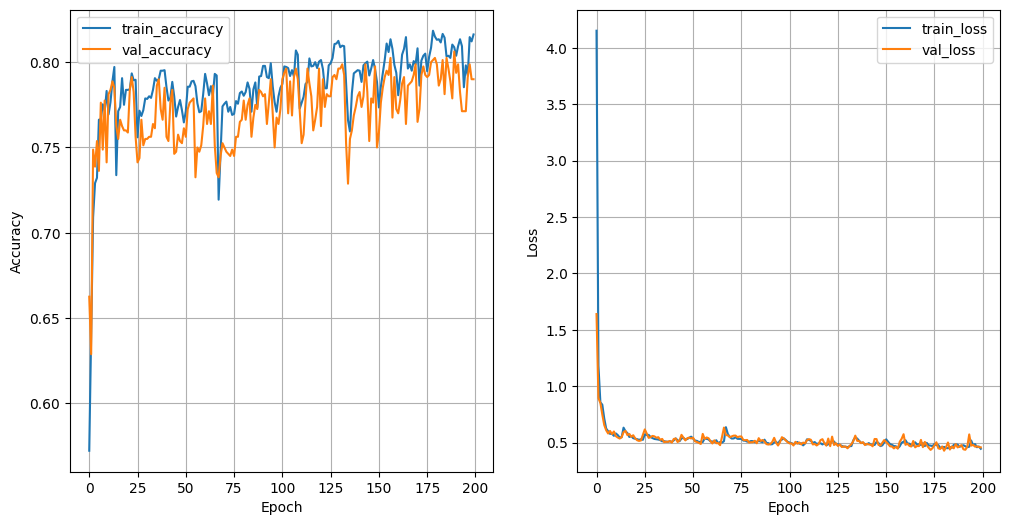

In [10]:
# Mostrar la historia de entrenamiento en diagramas
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Accuracy
    axs[0].plot(history.history['accuracy'], label='train_accuracy')
    axs[0].plot(history.history['val_accuracy'], label='val_accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].grid()
    axs[0].legend()

    # Pérdida
    axs[1].plot(history.history['loss'], label='train_loss')
    axs[1].plot(history.history['val_loss'], label='val_loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].grid()
    axs[1].legend()

    # Obteniendo el nombre de la imagen para la gráfica de entrenamiento
    cant_img_train = len(os.listdir(path="repeticiones_experimento/imagenes_entrenamientos"))
    name_img_train = f"imagen_entrenamiento_{cant_img_train+1}.png"
    plt.savefig(f"repeticiones_experimento/imagenes_entrenamientos/{name_img_train}", dpi=600, bbox_inches='tight')

    plt.show()

plot_history(history)

## **Parte 5:** Evaluación del modelo

Se evalua el mejor modelo guardado

In [11]:
mejor_modelo = load_model("modelo_generado/mejor_modelo.keras")
resul_eva = mejor_modelo.evaluate(x=X_val_reshaped, y=y_val, verbose=False)

# Obtener los resultados de pérdida y accuracy
perdida = resul_eva[0]
accuracy = resul_eva[1]

print("Loss: {:.4f}".format(perdida))
print("Accuracy: {:.4%}".format(accuracy))

#Crear un Dataframe con los nuevos resultados
new_data = pd.DataFrame({"Loss":[perdida], "Accuracy":[accuracy]})

#Especificar el nombre del archivo Excel
file_name = "resultados_iteraciones/resultados.xlsx"

#Verificar si el archivo ya existe
if os.path.exists(file_name):
    #Si el archivo existe, cargar los datos existentes
    existing_data = pd.read_excel(file_name, sheet_name="Resultados")
    #Concatenar los datos existentes con los nuevos datos
    df = pd.concat([existing_data, new_data], ignore_index=True)
else:
    #Si el archivo no existe, usar solo los nuevos datos
    df = new_data

#Guardar el Dataframe en el archivo Excel
df.to_excel(file_name, sheet_name="Resultados", index=False)

Loss: 0.4782
Accuracy: 80.6250%


Cálculo de diferentes métricas


Matriz de Confusión:


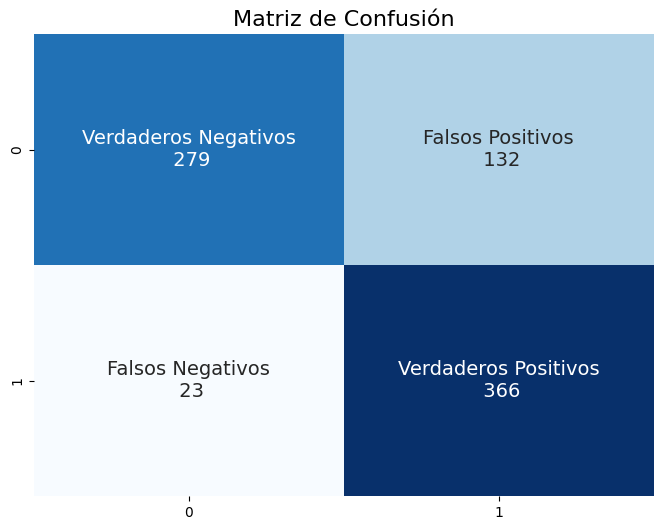

Accuracy:	80.62%
Sensitivity:	94.09%
Specificity:	67.88%
Precision:	73.49%
F1-score:	82.53%


In [12]:
y_pred_prob = mejor_modelo.predict(X_val_reshaped, verbose=False)

# Convertir las probabilidades en clases binarias usando un umbral (por ejemplo, 0.85)
y_pred = (y_pred_prob > 0.5).astype(int)

#Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true=y_val, y_pred=y_pred)

# Calcular métricas
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Calcular sensitivity y specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Imprimir resultados
print("\nMatriz de Confusión:")

# Define las etiquetas para los valores en la matriz de confusión
labels = [['Verdaderos Negativos\n', 'Falsos Positivos\n'],
          ['Falsos Negativos\n', 'Verdaderos Positivos\n']]

# Crear una nueva matriz combinando la matriz de confusión y las etiquetas
annot_matrix = [['{} {}'.format(label, value) for label, value in zip(row_labels, row)] for row_labels, row in zip(labels, conf_matrix)]

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=annot_matrix, cmap='Blues', fmt='', cbar=False, annot_kws={'size':14})
plt.title('Matriz de Confusión', fontsize=16)

# Obteniendo el nombre de la imagen para la matriz de confusión
cant_img_matrix = len(os.listdir(path="repeticiones_experimento/imagenes_matriz_confusion"))
name_img_matrix = f"matriz_confusion_{cant_img_matrix+1}.png"
plt.savefig(f"repeticiones_experimento/imagenes_matriz_confusion/{name_img_matrix}", dpi=600, bbox_inches='tight')

plt.show()

print("Accuracy:\t{:.2%}".format(accuracy))
print("Sensitivity:\t{:.2%}".format(sensitivity))
print("Specificity:\t{:.2%}".format(specificity))
print("Precision:\t{:.2%}".format(precision))
print("F1-score:\t{:.2%}".format(f1))

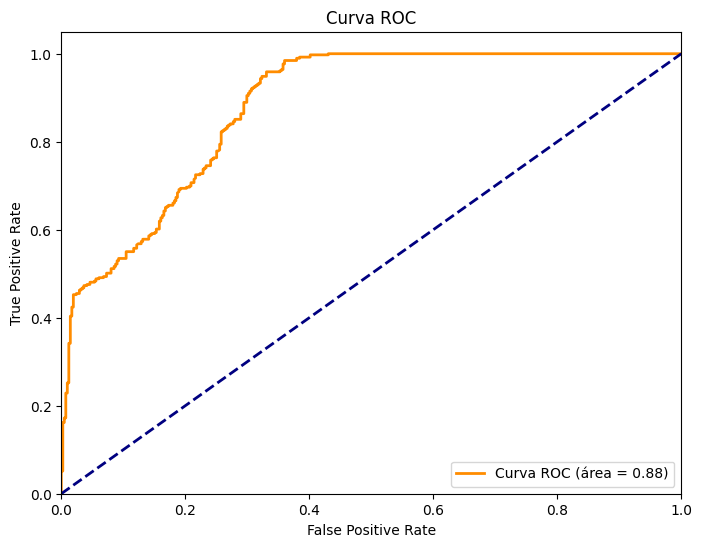

ROC-AUC:	0.88


In [13]:
# Calcular la curva ROC y el valor AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = roc_auc_score(y_val, y_pred_prob)

# Plotear la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Obteniendo el nombre de la imagen para la curva ROC-AUC
cant_img_roc_auc = len(os.listdir(path="repeticiones_experimento/imagenes_curvas_roc_auc"))
name_img_roc_auc = f"roc_auc{cant_img_roc_auc+1}.png"
plt.savefig(f"repeticiones_experimento/imagenes_curvas_roc_auc/{name_img_roc_auc}", dpi=600, bbox_inches='tight')

plt.show()

print("ROC-AUC:\t{:.2f}".format(roc_auc))

Se registran las métricas en cada iteración del experimento.

In [14]:
# Se crea un Dataframe con los nuevos resultados
new_data = pd.DataFrame({
    "Accuracy"      : [accuracy],
    "Sensitivity"   : [sensitivity],
    "Specificity"   : [specificity],
    "Precision"     : [precision],
    "F1"            : [f1],
    "Roc-Auc"       : [roc_auc]
})

# Especificar el nombre del archivo Excel
file_name = "repeticiones_experimento/metricas.xlsx"

#Verificar si el archivo ya existe
if os.path.exists(file_name):
    #Si el archivo existe, cargar los datos existentes
    existing_data = pd.read_excel(file_name, sheet_name="Métricas")
    #Concatenar los datos existentes con los nuevos datos
    df_metricas = pd.concat([existing_data, new_data], ignore_index=True)
else:
    #Si el archivo no existe, usar solo los nuevos datos
    df_metricas = new_data

#Guardar el Dataframe en el archivo Excel
df_metricas.to_excel(file_name, sheet_name="Métricas", index=False)